# garbage_classifier

This notebook classifies website text snippets into useful or not (i.e., garbage) using transfer learning starting from an existing hugging face model
* Get a model checkpoint for an encoder model 
* Use reinforcement learning to apply the model on a new classification problem (EAGER website data) with limited new trained data
* Apply new head of model to full EAGER corpus to come up with mixes of models
* Metrics and model registered through a combination of comet.ml and tensorboard 

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul 27 18:56:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [71]:
results_file = '/content/drive/MyDrive/raaste-results/garbage-classifier-results.csv'
company_file_dir = '/content/EAGER/data/orgs/parsed_page_output'
garbage_out_file_dir = '/content/EAGER/data/orgs/keep'
target = "keep_text" # change to of_interest if desired

## Install and import libraries

In [3]:
COMET_PROJECT_NAME = "eager-garbage-classifier"

In [4]:
# check environment
import sys
IN_COLAB = 'google.colab' in sys.modules
print (IN_COLAB)

True


In [5]:
# colab file system setup 
if IN_COLAB: 
    !git clone https://github.com/euphonic/EAGER.git
    !pwd
    !mkdir /content/logs

fatal: destination path 'EAGER' already exists and is not an empty directory.
/content
mkdir: cannot create directory ‘/content/logs’: File exists


In [6]:
# mount google drive if in colab
drive_path = '/content/drive/'

if IN_COLAB:  
    from google.colab import drive
    drive.mount(drive_path, force_remount=True)

Mounted at /content/drive/


In [7]:
# install huggingface and other modules if in colab
if IN_COLAB: 
    !pip install transformers
    !pip install datasets
    !pip install python-dotenv
    !pip install comet_ml
    !pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 101 kB 2.0 MB/s 
     |████████████████████████████████| 596 kB 87.5 MB/s 
     |████████████████████████████████| 6.6 MB 60.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 5.0 MB/s 
     |████████████████████████████████| 140 kB 70.0 MB/s 
     |████████████████████████████████| 212 kB 73.8 MB/s 
     |████████████████████████████████| 127 kB 88.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver 

In [7]:
from comet_ml import Experiment
from comet_ml.api import API
from dotenv import load_dotenv

# setup comet_ml experiment
if IN_COLAB: 
    # read env file from Google drive 
    env_file = drive_path + 'MyDrive/raaste-config/.env'
    comet_config_file = drive_path + 'MyDrive/raaste-config/.comet.config'
    load_dotenv(env_file)

In [44]:
# ml libs
from transformers import pipeline, AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding, \
  AutoConfig, TFBertForSequenceClassification
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split

# data and viz libs 
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# other
import numpy as np
import gzip
import tarfile
import datetime
import os
from tqdm import tqdm 
import csv
import evaluate

In [11]:
if IN_COLAB: 
    !pip uninstall -y comet_ml
    !pip install comet_ml

Found existing installation: comet-ml 3.31.7
Uninstalling comet-ml-3.31.7:
  Successfully uninstalled comet-ml-3.31.7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached comet_ml-3.31.7-py2.py3-none-any.whl (373 kB)


In [9]:
# load tensorboard 
%load_ext tensorboard

## EDA

In [58]:
firm_file_location = '/content/EAGER/data/modeling/garbage/garbage_classifier_input_keep_text.csv'
input_df = pd.read_csv(firm_file_location)
print(input_df.shape)

(5624, 2)


In [59]:
# inspect duplicates manually 
dup_df = input_df[input_df.duplicated('sample_text', keep=False)]
tmp_out_dir = '/content/tmp/'
os.makedirs(tmp_out_dir, exist_ok=True)  
dup_df.to_csv(tmp_out_dir + '/dup_df.csv', ',')

In [60]:
# remove duplicates and nulls
non_dup_df = input_df[~input_df.duplicated('sample_text', keep="first")]
print (non_dup_df.shape) 
non_null_df = non_dup_df[~ non_dup_df['sample_text'].isnull() ]
print (non_null_df.shape)

(4739, 2)
(4739, 2)


In [61]:
input_df['sample_text_len'] = input_df['sample_text'].str.len()
input_df.columns

Index(['sample_text', 'keep_text', 'sample_text_len'], dtype='object')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f13c5dc66d0>,
      dtype=object)

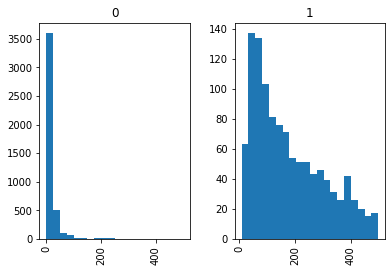

In [62]:
# text length by class
input_df[input_df['sample_text_len'] <=500]['sample_text_len'].hist(bins=20, by=input_df[target])

In [66]:
stopwords = set(STOPWORDS)
wc_keep = ' '.join(non_null_df[non_null_df[target] == 0]['sample_text'].str.lower().str.strip())
wc_garbage = ' '.join(non_null_df[non_null_df[target] == 1]['sample_text'].str.lower().str.strip())

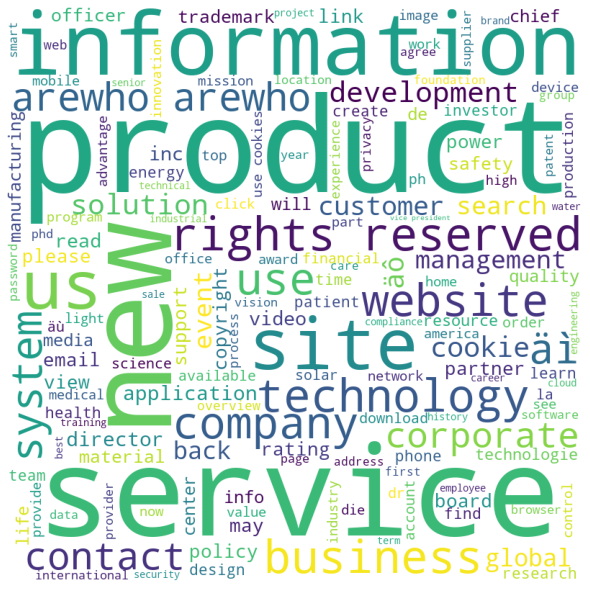

In [67]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(wc_keep)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

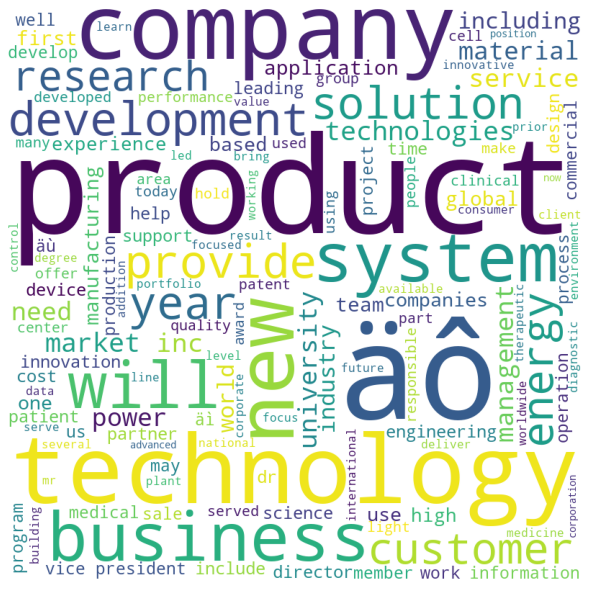

In [68]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(wc_garbage)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Model training
keep test == 1, discard == 0

In [14]:
# base bert
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [27]:
dataset = Dataset.from_pandas(non_null_df, split='train')
dataset.cast_column(target, datasets.Value('int8'))

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['sample_text', 'keep_text', '__index_level_0__'],
    num_rows: 4739
})

In [28]:
# 85% train, 15% test + validation
train_test_dataset = dataset.train_test_split(test_size=0.15)
# Split the 20% test + valid in half test, half valid
test_valid_dataset = train_test_dataset['test'].train_test_split(test_size=0.3)
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = datasets.DatasetDict({
    'train': train_test_dataset['train'],
    'test': test_valid_dataset['test'],
    'valid': test_valid_dataset['train']})

In [29]:
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['sample_text', 'keep_text', '__index_level_0__'],
        num_rows: 4028
    })
    test: Dataset({
        features: ['sample_text', 'keep_text', '__index_level_0__'],
        num_rows: 214
    })
    valid: Dataset({
        features: ['sample_text', 'keep_text', '__index_level_0__'],
        num_rows: 497
    })
})

In [30]:
def tokenize_function(x):
  return tokenizer(x["sample_text"], truncation=True, max_length=100)

In [31]:
tokenized_dataset = train_test_valid_dataset.map(tokenize_function, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [32]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sample_text', 'keep_text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4028
    })
    test: Dataset({
        features: ['sample_text', 'keep_text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 214
    })
    valid: Dataset({
        features: ['sample_text', 'keep_text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 497
    })
})

In [33]:
samples = tokenized_dataset["train"].to_dict()
samples = {k: v for k, v in samples.items() if k not in ["__index_level_0__", "sample_text"]}
for k, v in samples.items(): 
  print (k, v[0:5])

keep_text [0, 1, 0, 1, 0]
input_ids [[101, 4254, 102], [101, 5779, 3957, 2017, 2035, 1996, 5906, 2017, 2342, 2000, 2191, 1037, 4489, 1999, 5022, 1522, 20118, 3268, 1012, 2057, 2064, 2393, 2202, 2115, 13882, 2000, 1996, 2279, 2504, 1012, 102], [101, 2624, 5277, 1010, 6187, 102], [101, 2184, 1012, 6413, 2592, 19380, 1998, 4712, 1997, 4807, 102], [101, 3915, 102]]
token_type_ids [[0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0]]
attention_mask [[1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1]]


In [34]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="max_length", max_length=100, return_tensors="tf")

In [35]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'attention_mask': TensorShape([4028, 100]),
 'input_ids': TensorShape([4028, 100]),
 'keep_text': TensorShape([4028]),
 'token_type_ids': TensorShape([4028, 100])}

In [40]:
# config
config = AutoConfig.from_pretrained(checkpoint)
config.num_labels=1
config.hidden_dropout_prob = 0.2
config.attention_probs_dropout_prob = 0.2
config.hidden_size = 32
config.intermediate_size = 128
config.num_hidden_layers = 4
config.num_attention_heads = 4
print (type(config))

<class 'transformers.models.bert.configuration_bert.BertConfig'>


In [42]:
num_epochs = 50
batch_sizes = [64]
model_name = COMET_PROJECT_NAME.replace ('-', '_')

for bs in batch_sizes: 
  # read config file from git repo 
  experiment = Experiment(project_name=COMET_PROJECT_NAME)
  with experiment.train():
    experiment.log_parameter("batch_size", bs)

  # model
  model = TFAutoModelForSequenceClassification.from_config(config)
  print (type(model))

  print ('batch_size', bs)

  tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=target,
    shuffle=True,
    collate_fn=data_collator,
    batch_size=bs,
  )

  tf_validation_dataset = tokenized_dataset["valid"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=target,
    shuffle=False,
    collate_fn=data_collator,
    batch_size=bs,
  )

  # The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
  # by the total number of epochs
  num_train_steps = len(tf_train_dataset) * num_epochs
  lr_scheduler = PolynomialDecay(
      initial_learning_rate=5e-5, end_learning_rate=0, decay_steps=num_train_steps
  )

  opt = Adam(learning_rate=lr_scheduler, beta_1=0.9, beta_2=0.999)

  log_dir = "/content/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)    

  early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

  loss = tf.keras.losses.BinaryFocalCrossentropy(from_logits=True, gamma=2.0, label_smoothing=0.2) # gamma = 0 is equivalent to binary cross entropy
  model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

  model.fit(tf_train_dataset, validation_data=tf_validation_dataset, 
        epochs=num_epochs, callbacks=[tensorboard_callback, early_stopping_callback])
  
  # save model to disk -- can be added to for loop above

  model_save_path = '/content/models/' + model_name + "_" + str(bs)
  print (model_save_path)
  model.save_pretrained(model_save_path)
  experiment.log_model(name=model_name, file_or_folder=model_save_path)
  
  experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Experiment is live on comet.ml https://www.comet.com/euphonic/eager-garbage-classifier/efd566e4e4934826ae986930d55ab34c

COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging


<class 'transformers.models.bert.modeling_tf_bert.TFBertForSequenceClassification'>
batch_size 64
Epoch 1/50
63/63 [==============================] - 12s 68ms/step - loss: 0.1703 - accuracy: 0.7363 - val_loss: 0.1663 - val_accuracy: 0.7344
Epoch 2/50
63/63 [==============================] - 2s 36ms/step - loss: 0.1634 - accuracy: 0.7363 - val_loss: 0.1594 - val_accuracy: 0.7344
Epoch 3/50
63/63 [==============================] - 2s 34ms/step - loss: 0.1569 - accuracy: 0.7363 - val_loss: 0.1541 - val_accuracy: 0.7344
Epoch 4/50
63/63 [==============================] - 2s 34ms/step - loss: 0.1522 - accuracy: 0.7363 - val_loss: 0.1501 - val_accuracy: 0.7344
Epoch 5/50
63/63 [==============================] - 2s 34ms/step - loss: 0.1404 - accuracy: 0.7363 - val_loss: 0.1209 - val_accuracy: 0.7344
Epoch 6/50
63/63 [==============================] - 2s 34ms/step - loss: 0.1089 - accuracy: 0.7430 - val_loss: 0.0987 - val_accuracy: 0.7344
Epoch 7/50
63/63 [==============================] - 2s 

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/euphonic/eager-garbage-classifier/efd566e4e4934826ae986930d55ab34c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [25]                : (0.7363455891609192, 0.9828699231147766)
COMET INFO:     batch_accuracy [175]         : (0.7159090638160706, 1.0)
COMET INFO:     batch_loss [175]             : (0.01821393147110939, 0.1744079738855362)
COMET INFO:     epoch_duration [25]          : (2.141301181000017, 11.949612966999666)
COMET INFO:     loss [25]                    : (0.03138009458780289, 0.17033877968788147)
COMET INFO:     val_accuracy [25]            : (0.7344064116477966, 0.9275653958320618)
COMET INFO:     val_loss [25]                : (0.06752681732177734, 0.16631123423576355)
COMET INFO:     validate_batch_accuracy [2

## Out of sample testing
Run on final eval dataset only

In [43]:
# create test dataset
tf_test_dataset = tokenized_dataset["test"].to_tf_dataset (
  columns=["attention_mask", "input_ids", "token_type_ids"],
  label_cols=target,
  shuffle=False,
  collate_fn=data_collator,
  batch_size=bs,
)

In [44]:
# get list of strings and list of labels
eval_text = train_test_valid_dataset['test']['sample_text']
eval_labels = train_test_valid_dataset['test'][target]

# define inference pipeline
pipe = pipeline ("text-classification", model=model, tokenizer=tokenizer, device=0, batch_size = 8,function_to_apply='sigmoid' )
tokenizer_kwargs = {'padding':'max_length','truncation':True,'max_length':100}

In [45]:
# run pipeline
out = pipe (eval_text, **tokenizer_kwargs)

In [46]:
# calculate class predictions from sigmoids 
scores = np.asarray([o['score'] for o in out])

print ('scores: ' + str(scores[0:5]))
threshold = 0.5
preds = np.where(scores > threshold, 1, 0)
print ('preds: ' + str(preds[0:5]))

print ('eval labels: ' + str(eval_labels[0:5]))

scores: [0.14438505 0.14445899 0.14437461 0.14453477 0.14436297]
preds: [0 0 0 0 0]
eval labels: [0, 0, 0, 0, 0]


In [47]:
# run metrics
accuracy = evaluate.load("accuracy")
accuracy.compute(references=eval_labels, predictions=preds)

{'accuracy': 0.9392523364485982}

In [48]:
# which sample texts where incorrectly classified? 
for i in range (len(preds)):
  if (preds[i] != eval_labels[i]):
    print ('score: ' + str(scores[i]) + ' vs. label: ' + str(eval_labels[i]) )
    print ('\t' + eval_text[i])

score: 0.8048164248466492 vs. label: 0
	24 hours a day, 365 days a year Reportable power production
score: 0.22740907967090607 vs. label: 1
	Cultivating New, Next-generation business
score: 0.837432324886322 vs. label: 0
	Works naturally with flowers and plants to keep them fresh from the field during shipping and distribution
score: 0.8280507922172546 vs. label: 0
	(founded in 1978 as Great Lakes Feedscrews) has been successfully designing and manufacturing¬†
score: 0.5347334742546082 vs. label: 0
	JavaScript is disabled. In order to view the site properly, you need to enable JavaScript.
score: 0.8365586996078491 vs. label: 0
	partners with best-in-class companies looking to increase their opportunities in emerging markets. We build partnerships across sectors, from collaborations with leading solar manufacturers to mobile money integrations with the world‚Äôs largest mobile network operators. Through our partnerships, we support businesses as they increase their reach, build consumer

## Register model

In [49]:
# save best run (confirm this through comet ml portal)
best_run = 'euphonic/' + COMET_PROJECT_NAME + '/convinced_beaver_3758'
version = "1.0.4"
api = API()
api_exp = api.get(best_run)
api_exp.register_model(model_name, version=version)

COMET INFO: Successfully registered 'eager-garbage-classifier', version '1.0.4' in workspace 'euphonic'


{'registryModelId': 'dyXSwgVHtuYcesXa63lRU7TUh',
 'registryModelItemId': 'cQ2JmnFhksSrzaVdkXj7ZZmPD'}

## Make predictions
Write results out to file for manual DQ

In [50]:
# download latest model
best_run = 'euphonic/' + COMET_PROJECT_NAME + '/convinced_beaver_3758'
version = "1.0.4" # need to set manually for now
api = API()
api.download_registry_model("euphonic", COMET_PROJECT_NAME, version,
                            output_path="/content/registered_models/", expand=True)

COMET INFO: Downloading registry model 'eager-garbage-classifier', version '1.0.4', stage None from workspace 'euphonic'...
COMET INFO: Unzipping model to '/content/registered_models' ...
COMET INFO: done!


In [51]:
 # optional retrieve model from registry
local_model_dir = 'eager_garbage_classifier_64' # need to set manually for now
model = TFBertForSequenceClassification.from_pretrained ('/content/registered_models/' + local_model_dir)

Some layers from the model checkpoint at /content/registered_models/eager_garbage_classifier_64 were not used when initializing TFBertForSequenceClassification: ['dropout_111']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/registered_models/eager_garbage_classifier_64.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [52]:
# open file dir, read files and run predictions. aggregate results in a list object
data_for_df = []

for filename in os.listdir(company_file_dir):
  if filename.endswith('.txt'):
    with open( os.path.join(company_file_dir, filename) ) as file_h:
      co_text = [line for line in file_h]
      co_id = np.repeat (filename, len(co_text))
      co_index = np.arange (0, len(co_text))
      L = list(zip(co_id, co_index, co_text))
      data_for_df.append (L)

In [53]:
# transfer results to dataframe
dq_check_df = pd.DataFrame([t for lst in data_for_df for t in lst], columns = ['firm_name_txt', 'index', 'sample_text'])
dq_check_df

,firm_name_txt,index,sample_text
0,ADASA.txt,0,Search\n
1,ADASA.txt,1,All dresses\n
2,ADASA.txt,2,Shop by dresses\n
3,ADASA.txt,3,Long dresses\n
4,ADASA.txt,4,Short dresses\n
...,...,...,...
2096117,NCC Nano.txt,63,"As the Marketing and Events Manager, you will ..."
2096118,NCC Nano.txt,64,"Location: North Austin-Round Rock, Texas\n"
2096119,NCC Nano.txt,65,"As an Application Engineer, you will be engage..."
2096120,NCC Nano.txt,66,"Headquartered in Austin, TX, NovaCentrix offer..."


In [54]:
# lower case text 
dq_check_df['sample_text_lower'] = dq_check_df['sample_text'].str.lower()
dq_check_df

,firm_name_txt,index,sample_text,sample_text_lower
0,ADASA.txt,0,Search\n,search\n
1,ADASA.txt,1,All dresses\n,all dresses\n
2,ADASA.txt,2,Shop by dresses\n,shop by dresses\n
3,ADASA.txt,3,Long dresses\n,long dresses\n
4,ADASA.txt,4,Short dresses\n,short dresses\n
...,...,...,...,...
2096117,NCC Nano.txt,63,"As the Marketing and Events Manager, you will ...","as the marketing and events manager, you will ..."
2096118,NCC Nano.txt,64,"Location: North Austin-Round Rock, Texas\n","location: north austin-round rock, texas\n"
2096119,NCC Nano.txt,65,"As an Application Engineer, you will be engage...","as an application engineer, you will be engage..."
2096120,NCC Nano.txt,66,"Headquartered in Austin, TX, NovaCentrix offer...","headquartered in austin, tx, novacentrix offer..."


In [55]:
# remove duplicates
dq_check_no_dup_df = dq_check_df[~dq_check_df.duplicated('sample_text_lower', keep="first")]
dq_check_no_dup_df

,firm_name_txt,index,sample_text,sample_text_lower
0,ADASA.txt,0,Search\n,search\n
1,ADASA.txt,1,All dresses\n,all dresses\n
2,ADASA.txt,2,Shop by dresses\n,shop by dresses\n
3,ADASA.txt,3,Long dresses\n,long dresses\n
4,ADASA.txt,4,Short dresses\n,short dresses\n
...,...,...,...,...
2096115,NCC Nano.txt,61,Why work here? The chance to have a meaningful...,why work here? the chance to have a meaningful...
2096116,NCC Nano.txt,62,"Location: North Austin-Round Rock, Texas\n","location: north austin-round rock, texas\n"
2096117,NCC Nano.txt,63,"As the Marketing and Events Manager, you will ...","as the marketing and events manager, you will ..."
2096119,NCC Nano.txt,65,"As an Application Engineer, you will be engage...","as an application engineer, you will be engage..."


In [56]:
# build inference pipeline
pipe = pipeline ("text-classification", model=model, tokenizer=tokenizer, device=0, batch_size = 8,function_to_apply='sigmoid' )
tokenizer_kwargs = {'padding':'max_length','truncation':True,'max_length':100}

In [57]:
# create huggingface dataset structure
smaller_df = dq_check_no_dup_df.drop(columns=['sample_text'])
dq_check_ds = Dataset.from_pandas(smaller_df)
dq_check_ds

Dataset({
    features: ['firm_name_txt', 'index', 'sample_text_lower', '__index_level_0__'],
    num_rows: 272599
})

In [58]:
# run inference and store preds to results list of dicts
results = []

itr = 0
for kds in tqdm(KeyDataset(dq_check_ds, "sample_text_lower")):
  out = pipe (kds, **tokenizer_kwargs)[0]
  out['lower_text'] = kds
  results.append(out)
  
  itr += 1
  if (itr % 10000 == 0):
    print (out)

  4%|▎         | 10004/272599 [08:21<3:37:36, 20.11it/s]

{'label': 'LABEL_0', 'score': 0.1454552859067917, 'lower_text': 'lens model number chart\n'}


  7%|▋         | 20004/272599 [16:36<3:27:48, 20.26it/s]

{'label': 'LABEL_0', 'score': 0.799734890460968, 'lower_text': "the clc550, the world's first copying machine with anti-forgery technology, is introduced.\n"}


 11%|█         | 30002/272599 [24:48<3:18:08, 20.41it/s]

{'label': 'LABEL_0', 'score': 0.15206822752952576, 'lower_text': '2.3. electric power business\n'}


 15%|█▍        | 40003/272599 [32:59<3:09:57, 20.41it/s]

{'label': 'LABEL_0', 'score': 0.17541518807411194, 'lower_text': '15930 48th st., suite 110, phoenix, arizona 85048, u.s.a.\n'}


 18%|█▊        | 50001/272599 [41:10<3:00:57, 20.50it/s]

{'label': 'LABEL_0', 'score': 0.1472289264202118, 'lower_text': ': +66-2501-1100-1 : +66-2501-3356\n'}


 22%|██▏       | 60002/272599 [49:21<2:51:16, 20.69it/s]

{'label': 'LABEL_0', 'score': 0.8343235850334167, 'lower_text': "we're committed to workplace research and knowledge, which support our heritage of innovation.\n"}


 26%|██▌       | 70004/272599 [57:31<2:44:01, 20.59it/s]

{'label': 'LABEL_0', 'score': 0.1447838693857193, 'lower_text': '18 jan 2019\n'}


 29%|██▉       | 80004/272599 [1:05:56<2:37:20, 20.40it/s]

{'label': 'LABEL_0', 'score': 0.1444050818681717, 'lower_text': 'photos \n'}


 33%|███▎      | 90003/272599 [1:14:14<2:32:50, 19.91it/s]

{'label': 'LABEL_0', 'score': 0.14537738263607025, 'lower_text': 'extranet sections\n'}


 37%|███▋      | 100003/272599 [1:22:33<2:25:19, 19.80it/s]

{'label': 'LABEL_0', 'score': 0.8369259834289551, 'lower_text': 'he received his bachelor of science degree in accounting from bentley university and a master of business administration from southern new hampshire university.\n'}


 40%|████      | 110002/272599 [1:30:52<2:16:43, 19.82it/s]

{'label': 'LABEL_0', 'score': 0.1446334719657898, 'lower_text': 'grackle\n'}


 44%|████▍     | 120003/272599 [1:39:12<2:08:32, 19.79it/s]

{'label': 'LABEL_0', 'score': 0.1454763561487198, 'lower_text': '9,099,241\n'}


 48%|████▊     | 130003/272599 [1:47:24<1:57:22, 20.25it/s]

{'label': 'LABEL_0', 'score': 0.8309129476547241, 'lower_text': ' sets high standards for technical and operational performance throughout our supply chain,” said\xa0gino addiego, senior vice president of engineering, operations and quality at\xa0materials. “congratulate all our 2018 supplier excellence award recipients for their valuable contributions in helping deliver successful new products that enable major technology inflections for our customers.”\n'}


 51%|█████▏    | 140002/272599 [1:55:36<1:52:57, 19.57it/s]

{'label': 'LABEL_0', 'score': 0.8378666639328003, 'lower_text': 'makes grants that connect the company and its employees to the needs of our local communities.\n'}


 55%|█████▌    | 150002/272599 [2:04:03<1:43:47, 19.69it/s]

{'label': 'LABEL_0', 'score': 0.1444021314382553, 'lower_text': '+ info\n'}


 59%|█████▊    | 160001/272599 [2:12:30<1:32:38, 20.26it/s]

{'label': 'LABEL_0', 'score': 0.6455913186073303, 'lower_text': 'to expand 3production capacity with its new sherman, texas facility\n'}


 62%|██████▏   | 170002/272599 [2:20:57<1:28:05, 19.41it/s]

{'label': 'LABEL_0', 'score': 0.8370082378387451, 'lower_text': "to be one of hilton's most and sustainable hotels is a bold idea. with ecostruxure™ building, hilton dubai achieves up to a 44% increase in energy efficiency without sacrificing guest comfort.\n"}


 66%|██████▌   | 180004/272599 [2:29:24<1:15:57, 20.32it/s]

{'label': 'LABEL_0', 'score': 0.14450028538703918, 'lower_text': 'roic\n'}


 70%|██████▉   | 190003/272599 [2:37:50<1:10:51, 19.43it/s]

{'label': 'LABEL_0', 'score': 0.8110490441322327, 'lower_text': '@ who joined our class and introduced us to chemistry!  we all agreed… \n'}


 73%|███████▎  | 200002/272599 [2:46:19<1:01:28, 19.68it/s]

{'label': 'LABEL_0', 'score': 0.14466111361980438, 'lower_text': 'snug®\n'}


 77%|███████▋  | 210002/272599 [2:54:47<53:48, 19.39it/s]

{'label': 'LABEL_0', 'score': 0.14468029141426086, 'lower_text': ' converged systems \n'}


 81%|████████  | 220003/272599 [3:03:14<44:32, 19.68it/s]

{'label': 'LABEL_0', 'score': 0.14492589235305786, 'lower_text': 'distribution, inc.\n'}


 84%|████████▍ | 230002/272599 [3:11:41<35:59, 19.73it/s]

{'label': 'LABEL_0', 'score': 0.14443683624267578, 'lower_text': 'niaid\n'}


 88%|████████▊ | 240002/272599 [3:19:59<27:54, 19.46it/s]

{'label': 'LABEL_0', 'score': 0.14466704428195953, 'lower_text': 'chris mccall\n'}


 92%|█████████▏| 250002/272599 [3:28:25<19:08, 19.68it/s]

{'label': 'LABEL_0', 'score': 0.14823807775974274, 'lower_text': '4.43 trillion won\n'}


 95%|█████████▌| 260002/272599 [3:36:51<10:24, 20.17it/s]

{'label': 'LABEL_0', 'score': 0.14482273161411285, 'lower_text': 'capillary technologies\n'}


 99%|█████████▉| 270003/272599 [3:45:18<02:15, 19.18it/s]

{'label': 'LABEL_0', 'score': 0.8090834021568298, 'lower_text': 'comprehensive income to shareholders in 2017 was over $1.1 billion.\n'}


100%|██████████| 272599/272599 [3:47:29<00:00, 19.97it/s]


In [59]:
# write prediction results to file 
keys = results[0].keys()

with open(results_file, 'w') as res_f:
    dict_writer = csv.DictWriter(res_f, keys)
    dict_writer.writeheader()
    dict_writer.writerows(results)

## Impute predictions into full dataset

In [73]:
# read model prediction results file and store in dictionary
results_dict = {}

with open(results_file, mode='r') as res_f:
    reader = csv.reader(res_f)
    next(reader)
    results_dict = {rows[2].strip(): float(rows[1]) for rows in reader}

for k in list(results_dict.keys())[:10]:
  print (k, results_dict[k])

search 0.14435921609401703
all dresses 0.14438067376613617
shop by dresses 0.14490287005901337
long dresses 0.1444372981786728
short dresses 0.14445488154888153
plus size dresses 0.14537949860095978
winter formal 0.14450088143348694
new arrivals 0.14447008073329926
sale 0.1445479393005371
view all 0.14453206956386566


In [77]:
# cycle through original files and impute predictions 
for filename in os.listdir(company_file_dir):
  if filename.endswith('.txt'):
    with open( os.path.join(company_file_dir, filename) ) as file_h:
      print ("Working on " + filename)
      co_keep_text = []
      for line in file_h:
        lc_line = line.lower().strip()
        if (lc_line not in results_dict):
          print (lc_line)
        elif (results_dict[lc_line] > 0.5):
          co_keep_text.append(line)

  with open(garbage_out_file_dir + "/" + filename, 'w') as keep_f:
    for text in co_keep_text:
        keep_f.write(text)

Working on Corporation for National Research Initiatives.txt
Working on Janssen Biotech.txt
Working on Seiko Epson.txt
Working on Green Extraction Technologies.txt
Working on Crestovo.txt
Working on Soliton Lasers.txt
Working on GlassPoint Solar.txt
Working on SICPA Holding SA.txt
Working on Cristal USA.txt
Working on CERION.txt
Working on GENERAL MOTORS.txt
Working on Intellectual Keystone Technology.txt
Working on Pacific Biosciences of California.txt
Working on Shell Oil Company.txt
Working on UT-Battelle.txt
Working on Colgate-Palmolive Company.txt
Working on Furukawa Electric Co.txt
Working on UCB Pharma SA.txt
Working on Altivera.txt
Working on American Piledriving Equipment.txt
Working on Tufts Medical Center.txt
Working on Bayer Cropscience AG.txt
Working on Solvay Specialty Polymers USA.txt
Working on Continental Manufacturing.txt
Working on Calient Technologies.txt
Working on Carl Zeiss Meditec AG.txt
Working on Heidelberger Druckmaschinen AG.txt
Working on SELMAN AND ASSOCIA